In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# from src.vit_train import load_model_dir
# from src.vit_train import load_data, load_dataloaders
# from src.vit_viz import generate_predicted_vs_true_data

In [26]:
from src.vit_analysis import ViTAnalysis

model_dir = 'output/vit_1_complex_20220329_0dde'
vit_analysis = ViTAnalysis(model_dir)

In [472]:
from src.rna_seq_plotter import load_rna_plotter
from src.orf_plotter import ORFAnnotationPlotter

orf_plotter = ORFAnnotationPlotter()
rna_plotter = load_rna_plotter()

In [ ]:
#atts = vit_analysis.compute_attentions()

In [5]:
from src.vit_data import write_pickle, read_pickle

#write_pickle(atts, 'output/tmp_atts')
atts = read_pickle('output/tmp_atts')


In [6]:
atts.shape

(26562, 4, 16)

In [7]:
from einops.layers.torch import Rearrange

In [8]:
vectorize_att = Rearrange('b (r) (c) -> b (r c)')

In [10]:
import torch
atts_vectorized = vectorize_att(torch.Tensor(atts)).numpy()

In [87]:
atts_vectorized.shape

(26562, 64)

In [124]:
vit_analysis.predicted_tx.shape

(26562,)

In [155]:
cd_120_inds = np.arange(len(vit_analysis.vit_data))

cd_120_selected_atts = atts_vectorized[cd_120_inds]
cd_120_logtpm = vit_analysis.vit_data.transcription_unscaled[cd_120_inds]
cd_120_pred_logtpm = vit_analysis.predicted_tx[cd_120_inds]


In [545]:
import numpy as np
from sklearn.manifold import TSNE

cd_120_embedded = TSNE(n_components=2, learning_rate='auto', perplexity=120.,
                   init='random').fit_transform(cd_120_selected_atts)
cd_120_embedded.shape


(26562, 2)

In [555]:
def plot_tsne(cd_120_embedded, vit_analysis, select=None):

    if select is None:
        select = np.arange(len(cd_120_embedded))

    plt_embedded = cd_120_embedded[select]
    pred_transcription = cd_120_pred_logtpm[select]
    true_transcription = cd_120_logtpm[select]
    times = vit_analysis.vit_data.orf_times[select]

    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)

        
    plt_df = pd.DataFrame({'x': plt_embedded[:, 0], 
                           'y': plt_embedded[:, 1],
                           'true': true_transcription,
                           'pred': pred_transcription,
                          'time': times})
    
    plt.scatter(plt_df.x, plt_df.y,
                c=plt_df.true,
                s=1, cmap='RdYlBu_r')
    plt.title(f"True transcription, N={len(cd_120_embedded)}")
    plt.xticks([])
    plt.yticks([])
    cbar = plt.colorbar()

    plt.subplot(2, 2, 2)
    plt_df = plt_df.sort_values('pred')
    
    plt.title(f"2D t-SNE representation of\nlearned attentions, $n$={len(cd_120_embedded)}", fontsize=18, pad=10)
    plt.scatter(plt_df.x, plt_df.y, color='none', edgecolor='#d0d0d0',
        s=2, zorder=9, rasterized=True)
    
    
    plt.scatter(plt_df.x, plt_df.y,
                c=plt_df.pred, 
                s=3, cmap='RdYlBu_r', zorder=10, rasterized=True, edgecolors='none')
    plt.xticks([])
    plt.yticks([])
    cbar = plt.colorbar()
    cbar.ax.set_ylabel("Predicted transcript\nlevel, logTPM", rotation=-90, labelpad=30)

    plt.subplot(2, 2, 3)
    plt.title(f"Time, N={len(plt_embedded)}")
    
    plt_df = plt_df.sort_values('time')
    plt.scatter(plt_df.x, plt_df.y, c=plt_df.time, s=0.25, cmap='RdYlBu_r', vmin=0, vmax=120)
    plt.xticks([])
    plt.yticks([])
    cbar = plt.colorbar()


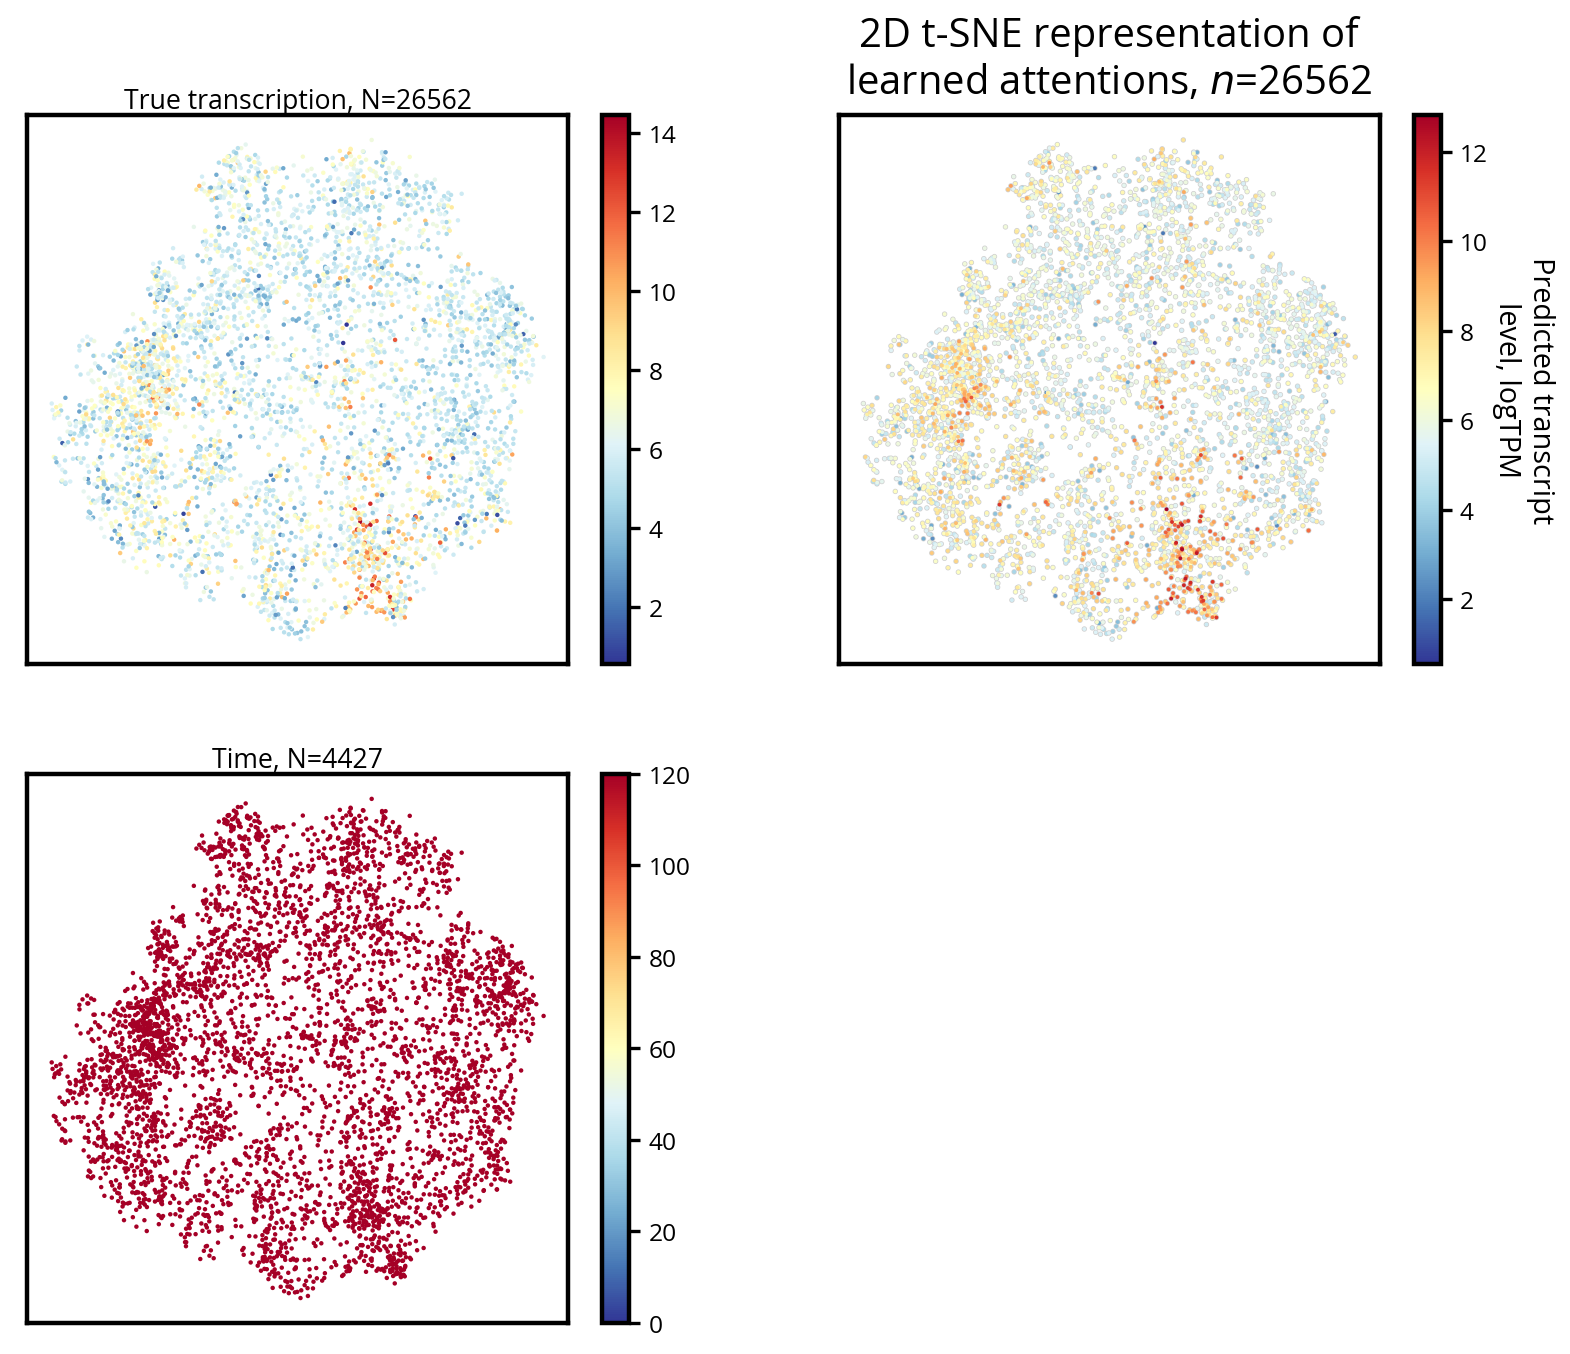

In [552]:
plot_tsne(cd_120_embedded, vit_analysis, (vit_analysis.vit_data.orf_times == 120))

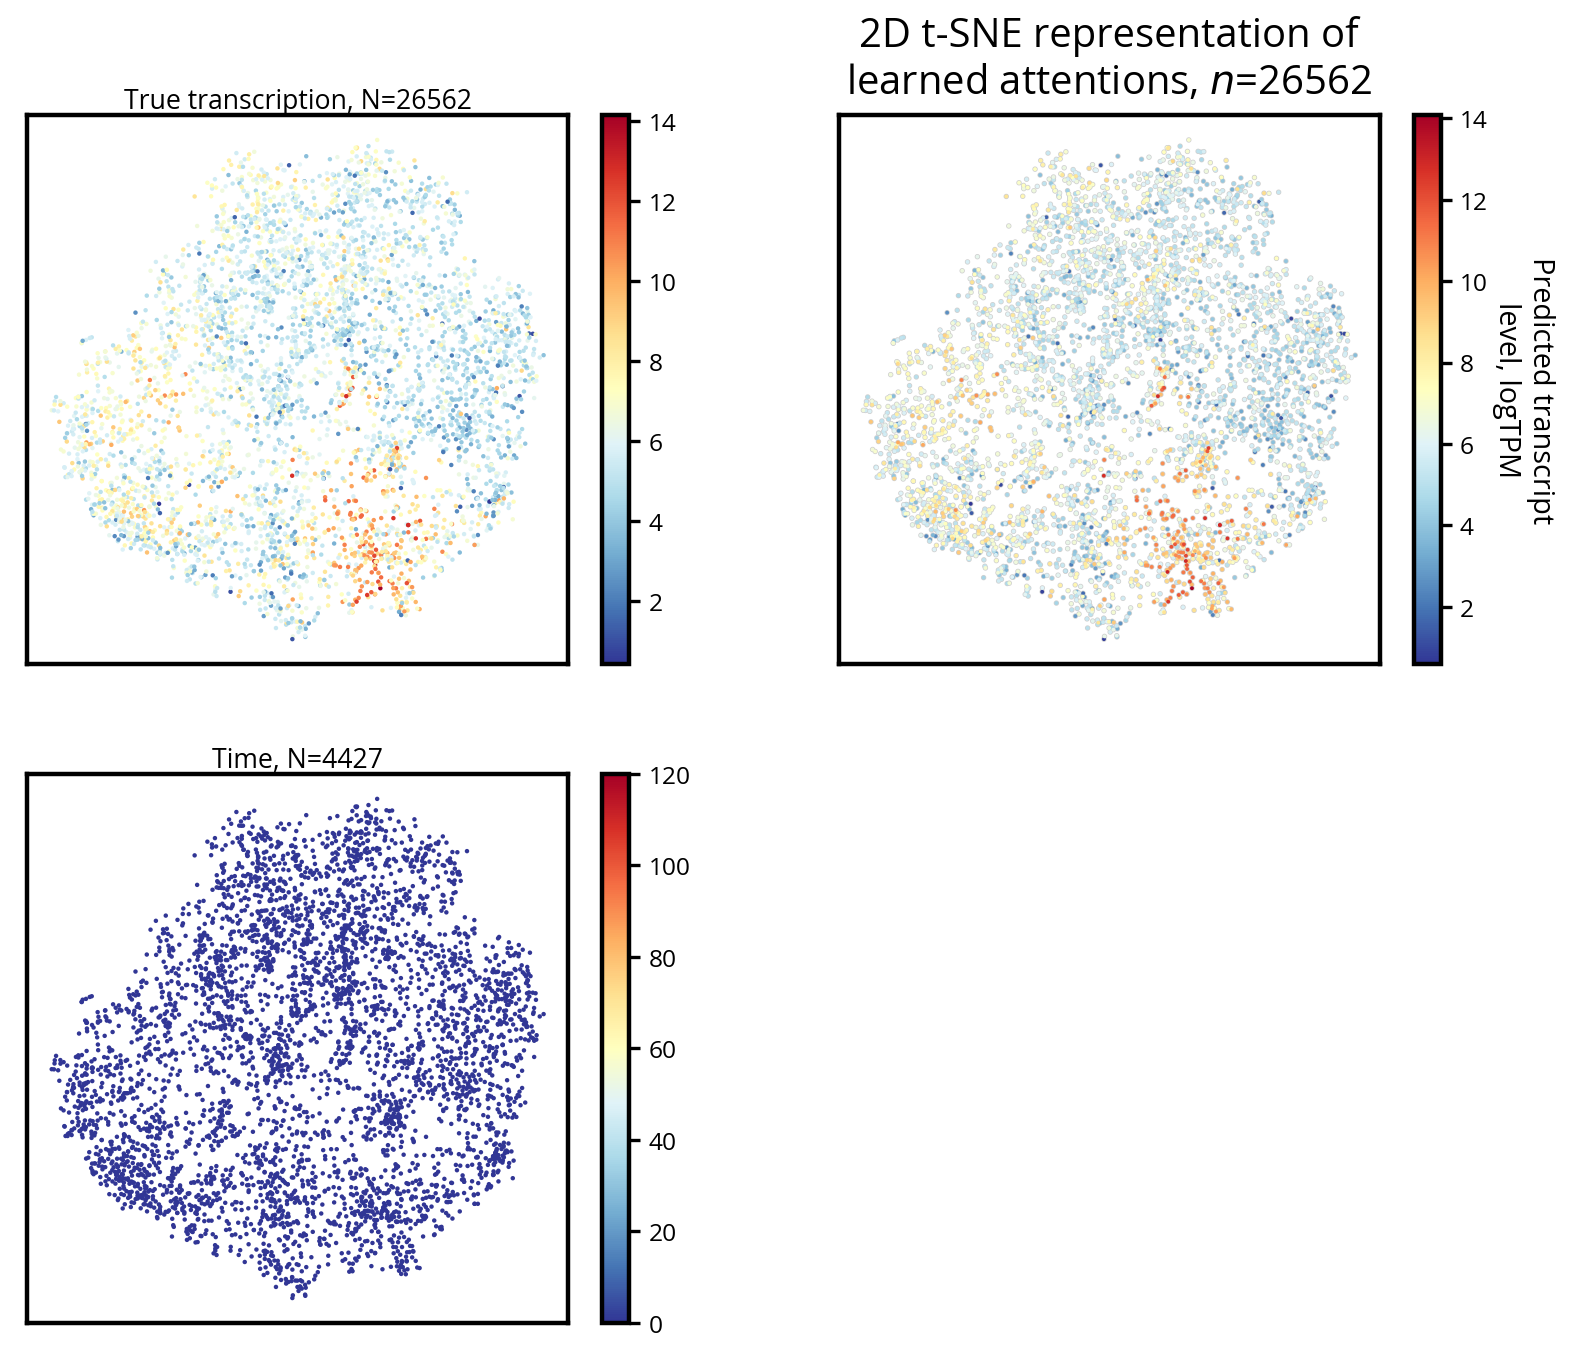

In [553]:
plot_tsne(cd_120_embedded, vit_analysis, (vit_analysis.vit_data.orf_times == 0))

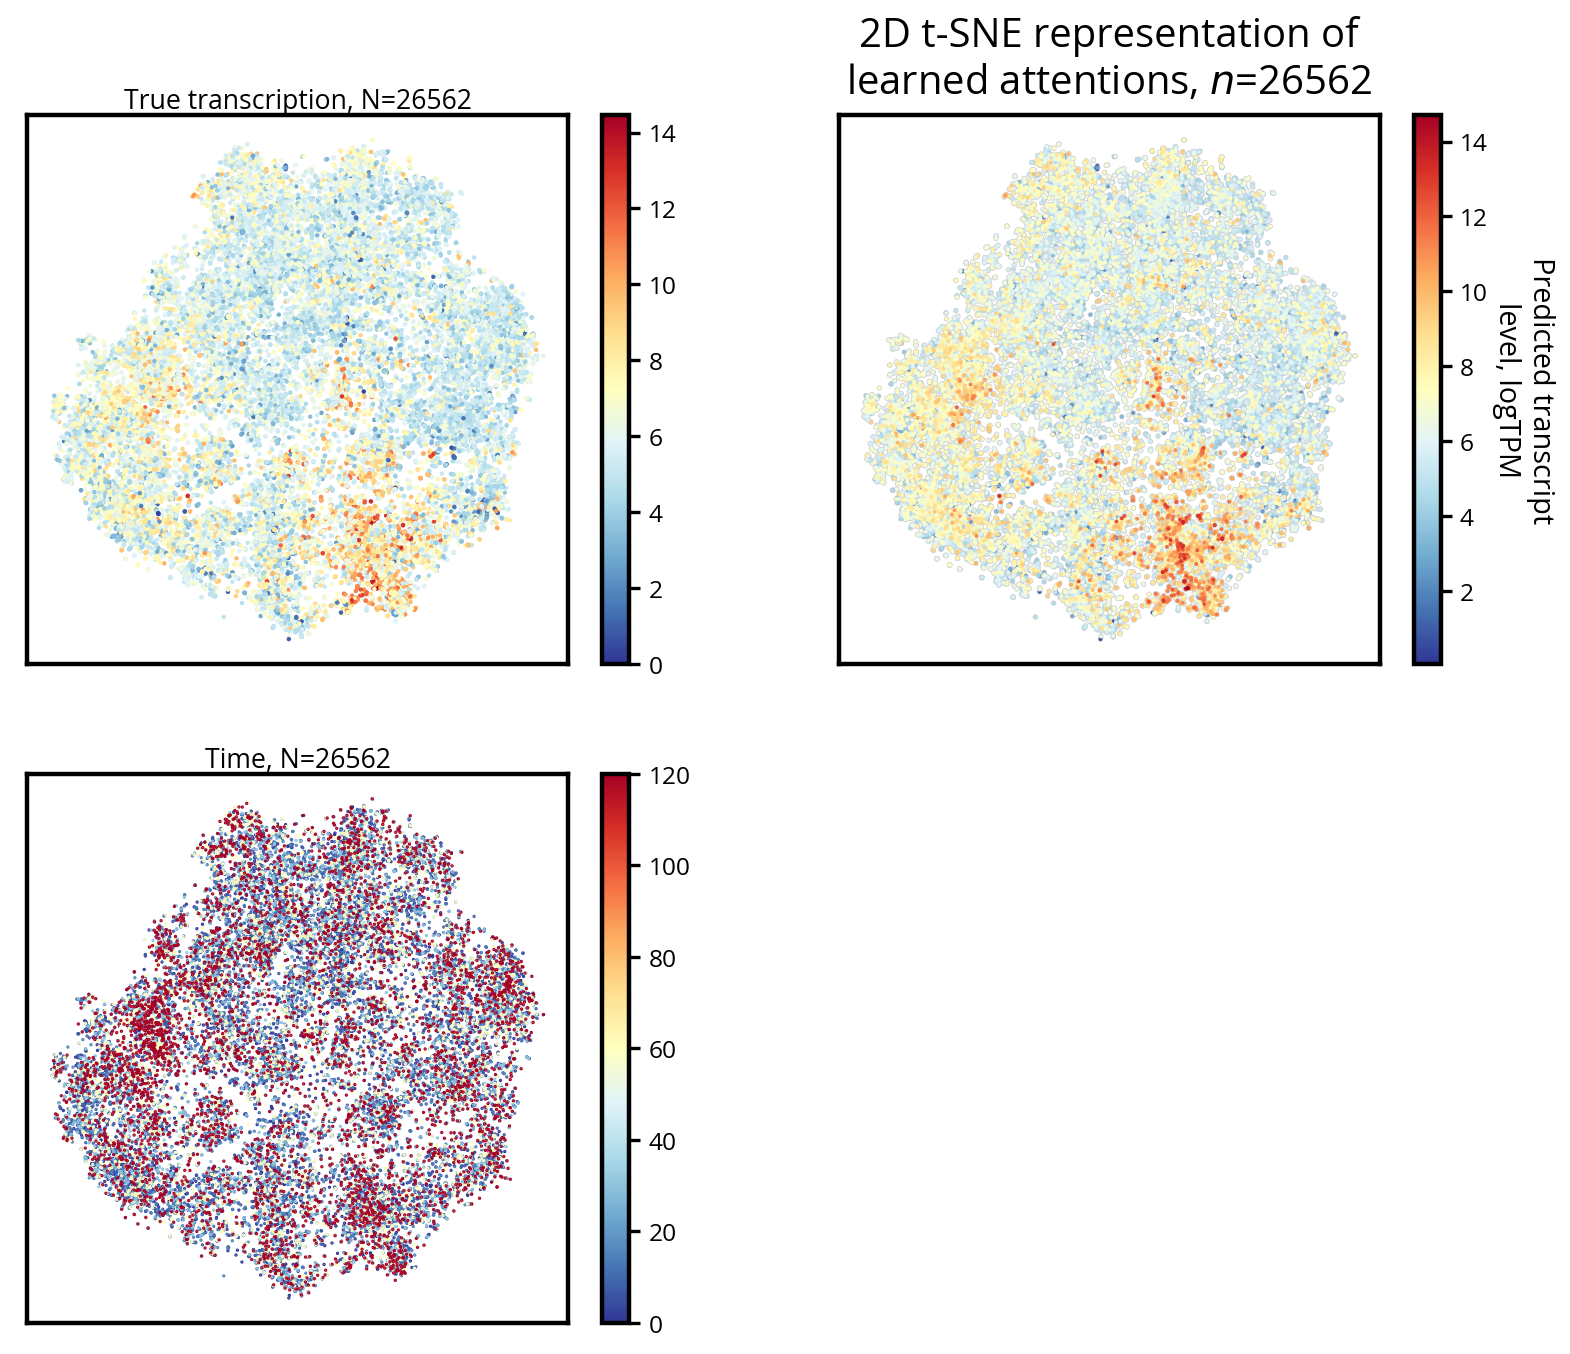

In [556]:
plot_tsne(cd_120_embedded, vit_analysis)
plt.savefig('output/clustering/tsne_transcription_plots.png', dpi=450)


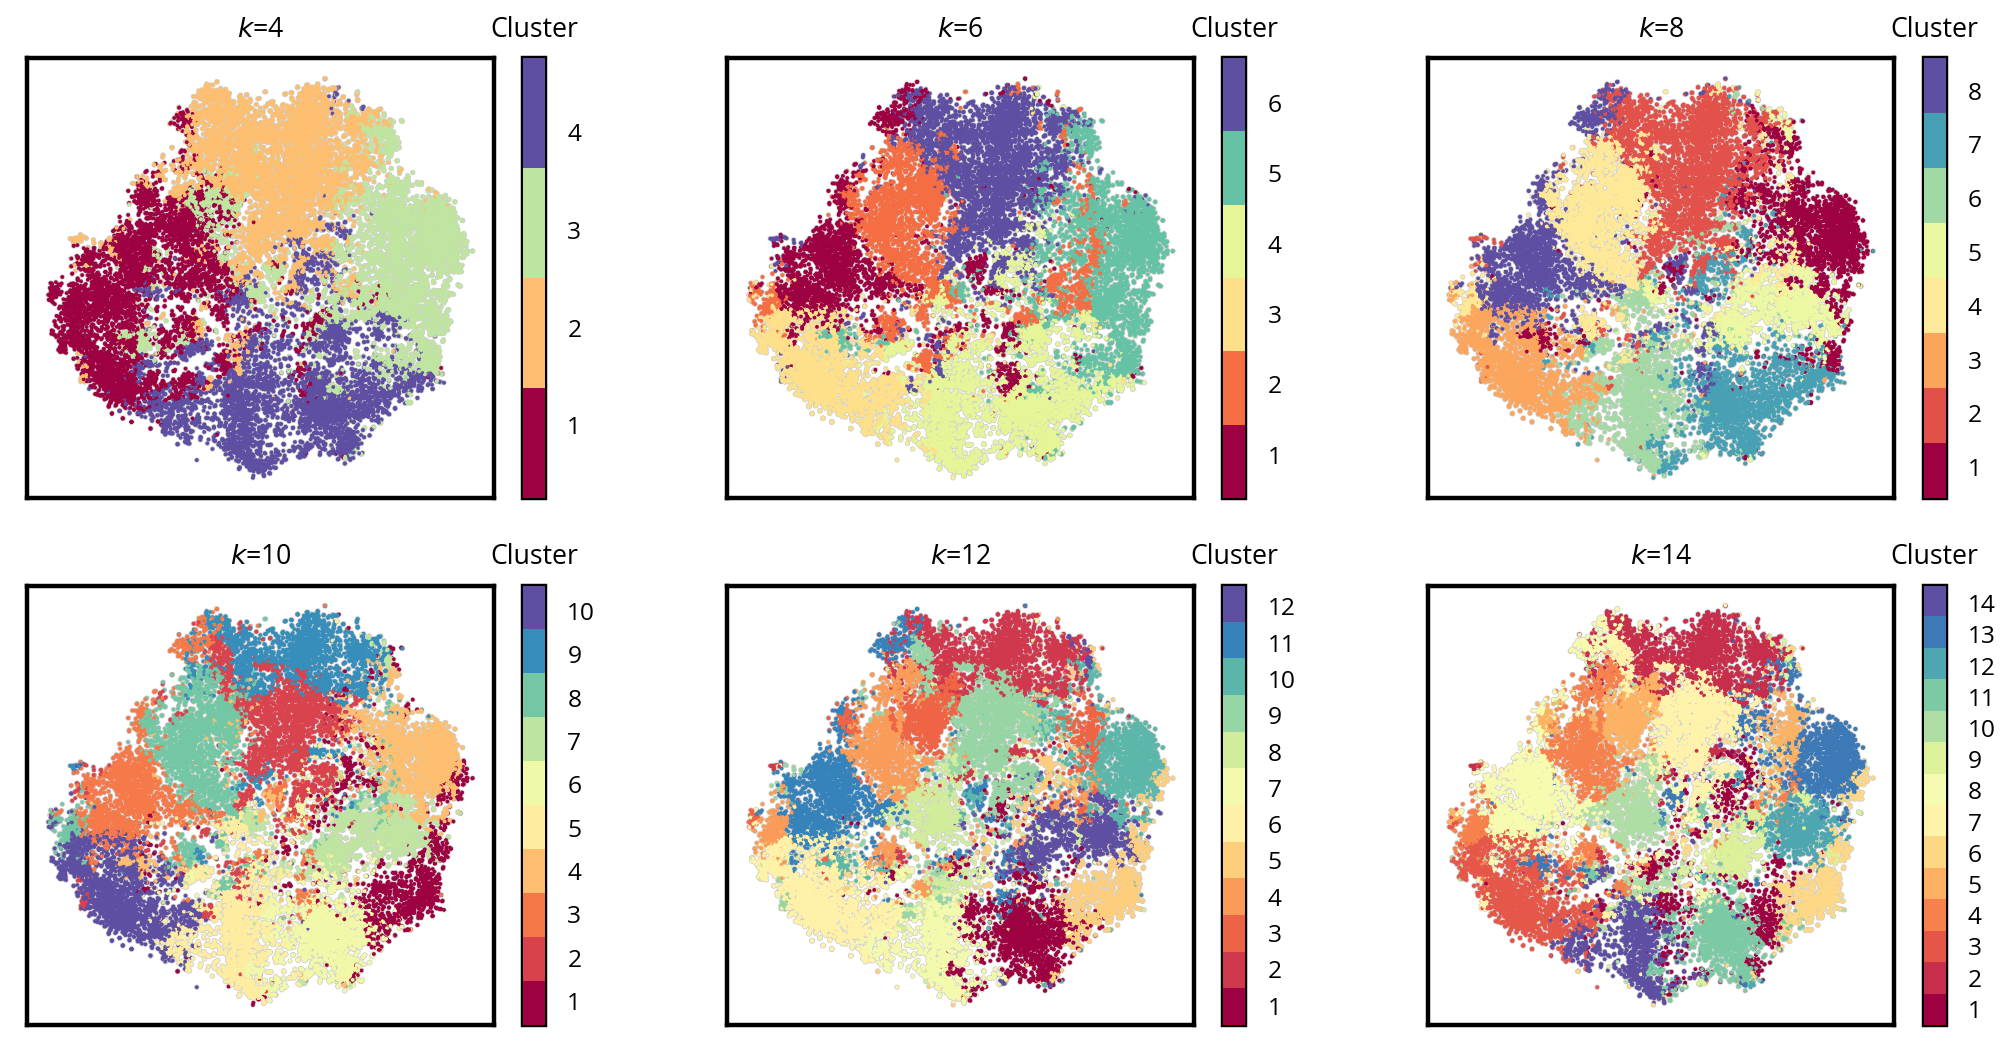

In [550]:
from sklearn.cluster import KMeans

plt.figure(figsize=(16, 8))
i = 1

for c in range(4, 16, 2):
    plt.subplot(2, 3, i)
    kmeans = KMeans(n_clusters=c, random_state=1).fit(cd_120_selected_atts)
    cd_120_cluster_labels = kmeans.labels_
    
    plt.scatter(cd_120_embedded[:, 0], cd_120_embedded[:, 1], color='none', edgecolor='#d0d0d0',
    s=2, zorder=9, rasterized=True)

    plt.scatter(cd_120_embedded[:, 0], cd_120_embedded[:, 1], c=(cd_120_cluster_labels+1),
                s=3, cmap='Spectral', edgecolors='none', rasterized=True, zorder=10)
    cbar = plt.colorbar()    
    cbar.ax.imshow(np.array([np.arange(c)+1]).T, cmap='Spectral_r', 
        extent=[0, 1, 1, c], zorder=10, aspect='auto')
    
    cbar.ax.set_yticks(np.linspace(1, c-1, c)+0.5)
    cbar.ax.set_yticklabels(np.arange(1, c+1))
    cbar.ax.set_title("Cluster", pad=10)
    cbar.ax.tick_params(axis='both', which='major', length=0, pad=10)

    plt.xticks([])
    plt.yticks([])

    plt.title(f"$k$={c}", pad=10)
    i+=1



plt.savefig('output/clustering/cluster_k_comparison.png', dpi=450)


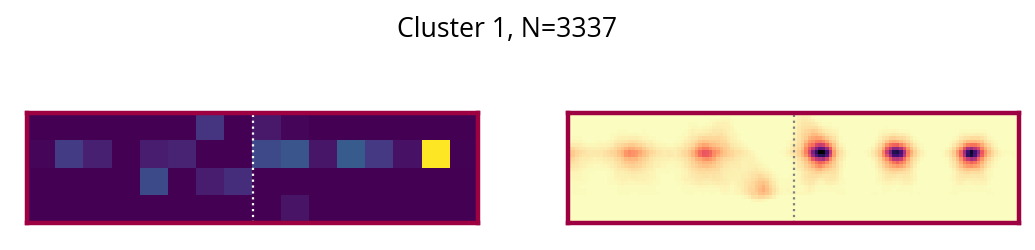

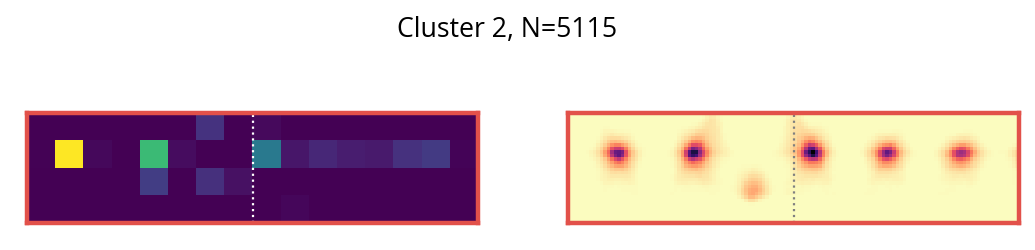

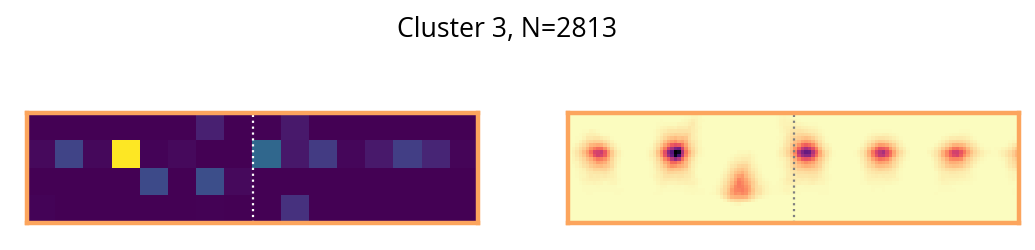

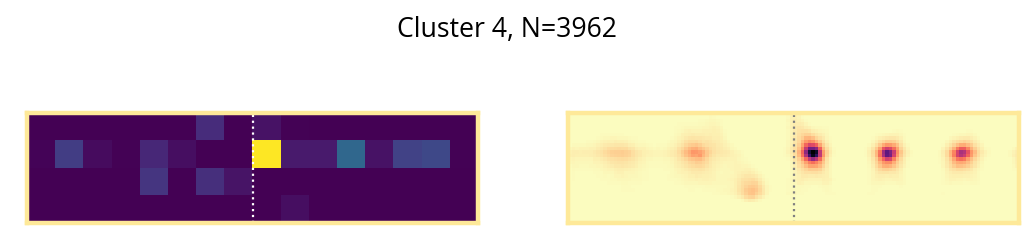

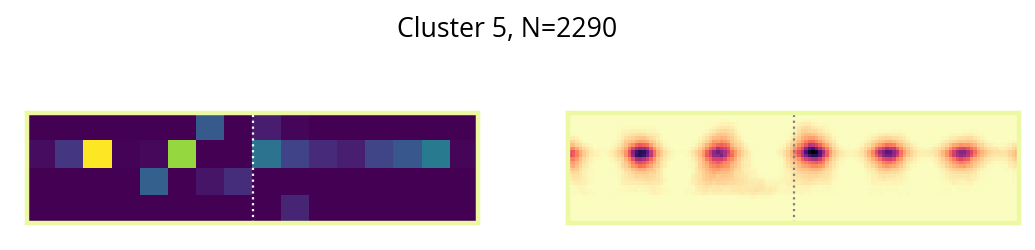

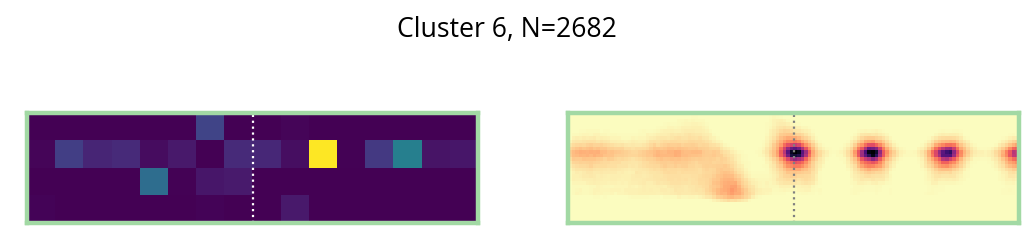

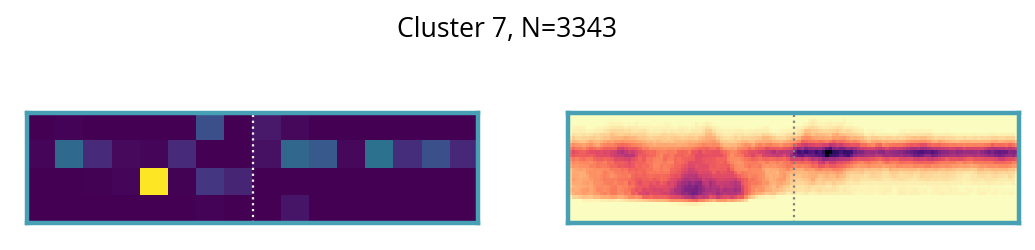

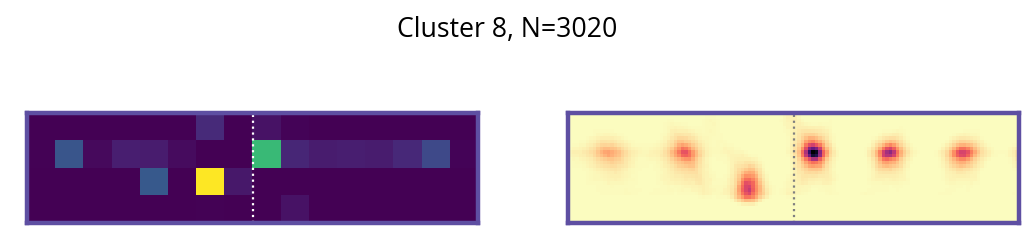

In [557]:
num_clust = 8
kmeans = KMeans(n_clusters=num_clust, random_state=1).fit(cd_120_selected_atts)
cd_120_cluster_labels = kmeans.labels_
    
for label in set(cd_120_cluster_labels):
    sel_indices = np.arange(len(cd_120_cluster_labels))[cd_120_cluster_labels == label]
    imgs = vit_analysis.vit_data[sel_indices][0]
    mean_img = imgs.mean(axis=0)[0]
    
    img_q25 = np.percentile(imgs, 25, axis=0)[0]
    img_q50 = np.percentile(imgs, 50, axis=0)[0]
    img_q75 = np.percentile(imgs, 75, axis=0)[0]
    
    att_imgs = atts[sel_indices]
    mean_att = att_imgs.mean(axis=0)
    q25 = np.percentile(att_imgs, 25, axis=0)
    q50 = np.percentile(att_imgs, 50, axis=0)
    q75 = np.percentile(att_imgs, 75, axis=0)
    color = plt.get_cmap('Spectral')(label/(num_clust-1))

    plt.figure(figsize=(8, 2))
    
    def format_axis(title, color):
        plt.title(title)
        ax = plt.gca()
        plt.xticks([])
        plt.yticks([])
        ax.spines['bottom'].set_color(color)
        ax.spines['top'].set_color(color) 
        ax.spines['right'].set_color(color)
        ax.spines['left'].set_color(color)
        [i.set_linewidth(2) for i in ax.spines.values()]

    #plt_imgs, subplt_i, title_i = [q25, q50, q75], [1, 3, 5], ['25%', '50%', '75%']
    plt_imgs, subplt_i, title_i = [q50], [1], ['']
    
    for i in range(len(plt_imgs)):
        plt.subplot(1, 2, subplt_i[i])
        plt.imshow(plt_imgs[i], origin='lower', extent=[-512, 512, 0, 250])
        format_axis(title_i[i], color)
        plt.axvline(0, c='white', lw=1, linestyle='dotted')
    
    # plt_imgs, subplt_i, title_i = [img_q25, img_q50, img_q75], [2, 4, 6], ['25%', '50%', '75%']
    plt_imgs, subplt_i, title_i = [img_q50], [2], ['']
        
    for i in range(len(plt_imgs)):
        plt.subplot(1, 2, subplt_i[i])
        plt.imshow(plt_imgs[i], origin='lower', cmap='magma_r', extent=[-512, 512, 0, 250])
        format_axis(title_i[i], color)
        plt.axvline(0, c='gray', lw=1, linestyle='dotted')
        
    plt.suptitle(f"Cluster {label+1}, N={len(imgs)}")
    plt.savefig(f'output/clustering/clusters_{num_clust}_{label+1}.png', dpi=150)


In [236]:
cluster_7_ind = np.arange(len(vit_analysis.vit_data))[cd_120_cluster_labels == 6]
#t120_inds = np.arange(len(vit_analysis.vit_data))[vit_analysis.vit_data.orf_times == 120]
sel_inds = cluster_7_ind#list(set(t120_inds).intersection(cluster_7_ind))

In [237]:
orfs = set(vit_analysis.vit_data.orf_names[sel_inds])

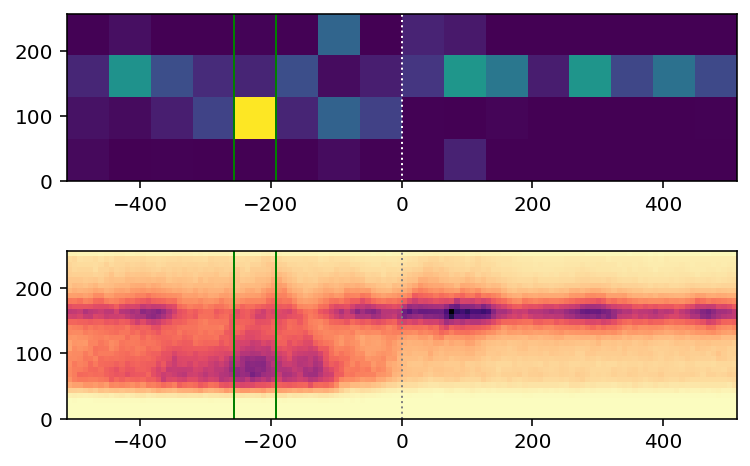

In [286]:
att_imgs = atts[sel_inds]
imgs = vit_analysis.vit_data[sel_inds][0]

region_span = -256, -192

plt.subplot(2, 1, 1)
plt.imshow(att_imgs.mean(axis=0), origin='lower', extent=[-512, 512, 0, 256])
plt.axvline(0, c='white', lw=1, linestyle='dotted')

for i in region_span:
    plt.axvline(i, lw=1, alpha=1., c='green')


plt.subplot(2, 1, 2)
plt.imshow(imgs.mean(axis=0)[0], origin='lower', cmap='magma_r', extent=[-512, 512, 0, 256])
plt.axvline(0, c='gray', lw=1, linestyle='dotted')

for i in region_span:
    plt.axvline(i, lw=1, alpha=1., c='green')
    

In [303]:
selected_orfs = vit_analysis.vit_data.orfs.loc[list(orfs)][['name', 'chr', 'TSS', 'strand']]

selected_orfs['region_start'] = selected_orfs.TSS + region_span[0]
selected_orfs['region_end'] = selected_orfs.TSS + region_span[1]

selected_orfs.loc[selected_orfs.strand == '-', 'region_start'] = selected_orfs.TSS - region_span[1]
selected_orfs.loc[selected_orfs.strand == '-', 'region_end'] = selected_orfs.TSS - region_span[0]

selected_orfs.head(2)

name  chr     TSS strand  region_start  region_end
orf_name                                                    
YBR111C   YSA1    2  461857      -        462049      462113
YGR142W   BTN2    7  772396      +        772140      772204

In [304]:
from src.genome import Genome

yeast_genome = Genome()

In [334]:
for orf_name, orf in selected_orfs.iterrows():
    seq = str(yeast_genome.read_sequence(orf.chr, (int(orf.region_start), int(orf.region_end)))[0])
    selected_orfs.loc[orf_name, 'region_sequence'] = seq

    seq_arr = np.array([nt for nt in seq])
    gc_count = ((seq_arr == 'G') | (seq_arr == 'C')).sum()
    gc_prop = gc_count / len(seq_arr)
    
    selected_orfs.loc[orf_name, 'gc'] = gc_prop
    

0

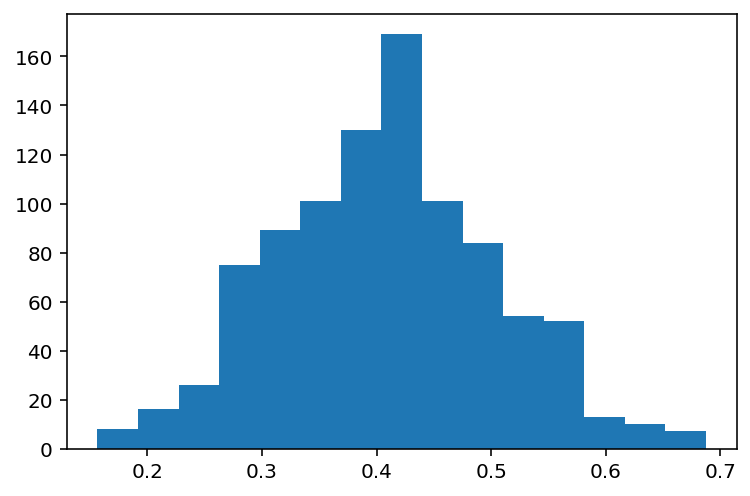

In [346]:
plt.hist(selected_orfs.gc, bins=15)
0

In [310]:
for o, s in selected_orfs.region_sequence.iteritems():
    print(f">{o}\n{s}")

>YBR111C
ATGAAAAATAAAAAATGAAAATTGCCATAGGCATGGCTTGACCAACACATGCGACAAAATCAGA
>YGR142W
GGTGGAGCTCGAGAGTTGTATCCAGTTTTCTTGTTCGGCGATATTCCGAACCAGGTCGGGTTGG
>YHL033C
ATCTGATGGCCTAGATATGTTTGGGTGTTTTCTTCATAATACTAGTGTTACAGTCATTTGAATA
>YJL052W
ATCTGGAGACTGGATCTTTACAATACAGTAAGGCAAGCCACCATCTGCTTCTTAGGTGCATGCG
>YNR018W
TCACGCTAAATAGCTGCTAACGATCAACACCTGACCGAGATAACAGCAGCAAAGAACCCGCAAA
>YIL133C
CATCGGGCTTAGCCAAGGGTCTCTGTTGCCGGGCATGGATACAGAGGGAGAAGTCTAGCATCGG
>YMR013C
AGAACTTTTTTCATTTCTGAAAATTTTTTTTTCTTCTAGGATTACTTCGGGTATAAATAAGAGA
>YHR150W
AGCTGCAAAAAAGTTTATCGCTTCGCGAAAAAAAAAAAAAAAAAAATTTAAAGAATTTCAAAAC
>YOR002W
TCGAATATCTGTGTCATGGAGTTATGGCTCCCCCATGCACACCATTTTCTCTTTTTTTGTTTCT
>YDL043C
GCACTTTTAAATTATTAAATTGCCTTCTACTTAGAGGGTTTTGGGATGTTCATCTGATGTAACG
>YDR043C
GCGTTTCGTTTCACGCTTAAGGGTCCTCAAGAGGCCATAGTCTTTTACCGATAAGAAAAATCTA
>YDR381W
TATATTTACAAAGTAAATACGTATATTAAAGCTATTTTACCACTACCACAGAGTTCTTTGTCCA
>YGL216W
AAGGCTTCATGGCCCTTTTTCAAACCTAATTTATAAGTTCTTTGCCCTATGCTTAAAACAGTTT
>YJL178C
TCTATGTCGGAGAACAAAAGTAGGCGTGG

In [363]:
pd.read_csv('/Users/trung/Downloads/fimo.tsv',
            sep='\t').dropna().groupby('motif_alt_id').count().sort_values('motif_id', ascending=False)

motif_id  sequence_name  start  stop  strand  score  p-value  \
motif_alt_id                                                                 
Azf1p              229            229    229   229     229    229      229   
Cbf1p              187            187    187   187     187    187      187   
Ste12p             186            186    186   186     186    186      186   
Mcm1p              162            162    162   162     162    162      162   
Mig1p              128            128    128   128     128    128      128   
...                ...            ...    ...   ...     ...    ...      ...   
Arg80p               5              5      5     5       5      5        5   
Nhp10p               4              4      4     4       4      4        4   
Sut2p                4              4      4     4       4      4        4   
Aca1p                2              2      2     2       2      2        2   
Abf2p                1              1      1     1       1      1        1   

              q-value  matched_sequence  
motif_alt_id                             
Azf1p             229               229  
Cbf1p             187               187  
Ste12p            186               186  
Mcm1p             162               162  
Mig1p             128               128  
...               ...               ...  
Arg80p              5                 5  
Nhp10p              4                 4  
Sut2p               4                 4  
Aca1p               2                 2  
Abf2p               1                 1  

[166 rows x 9 columns]

In [473]:
vit_analysis.orf_plotter = orf_plotter
vit_analysis.rna_plotter = rna_plotter

0

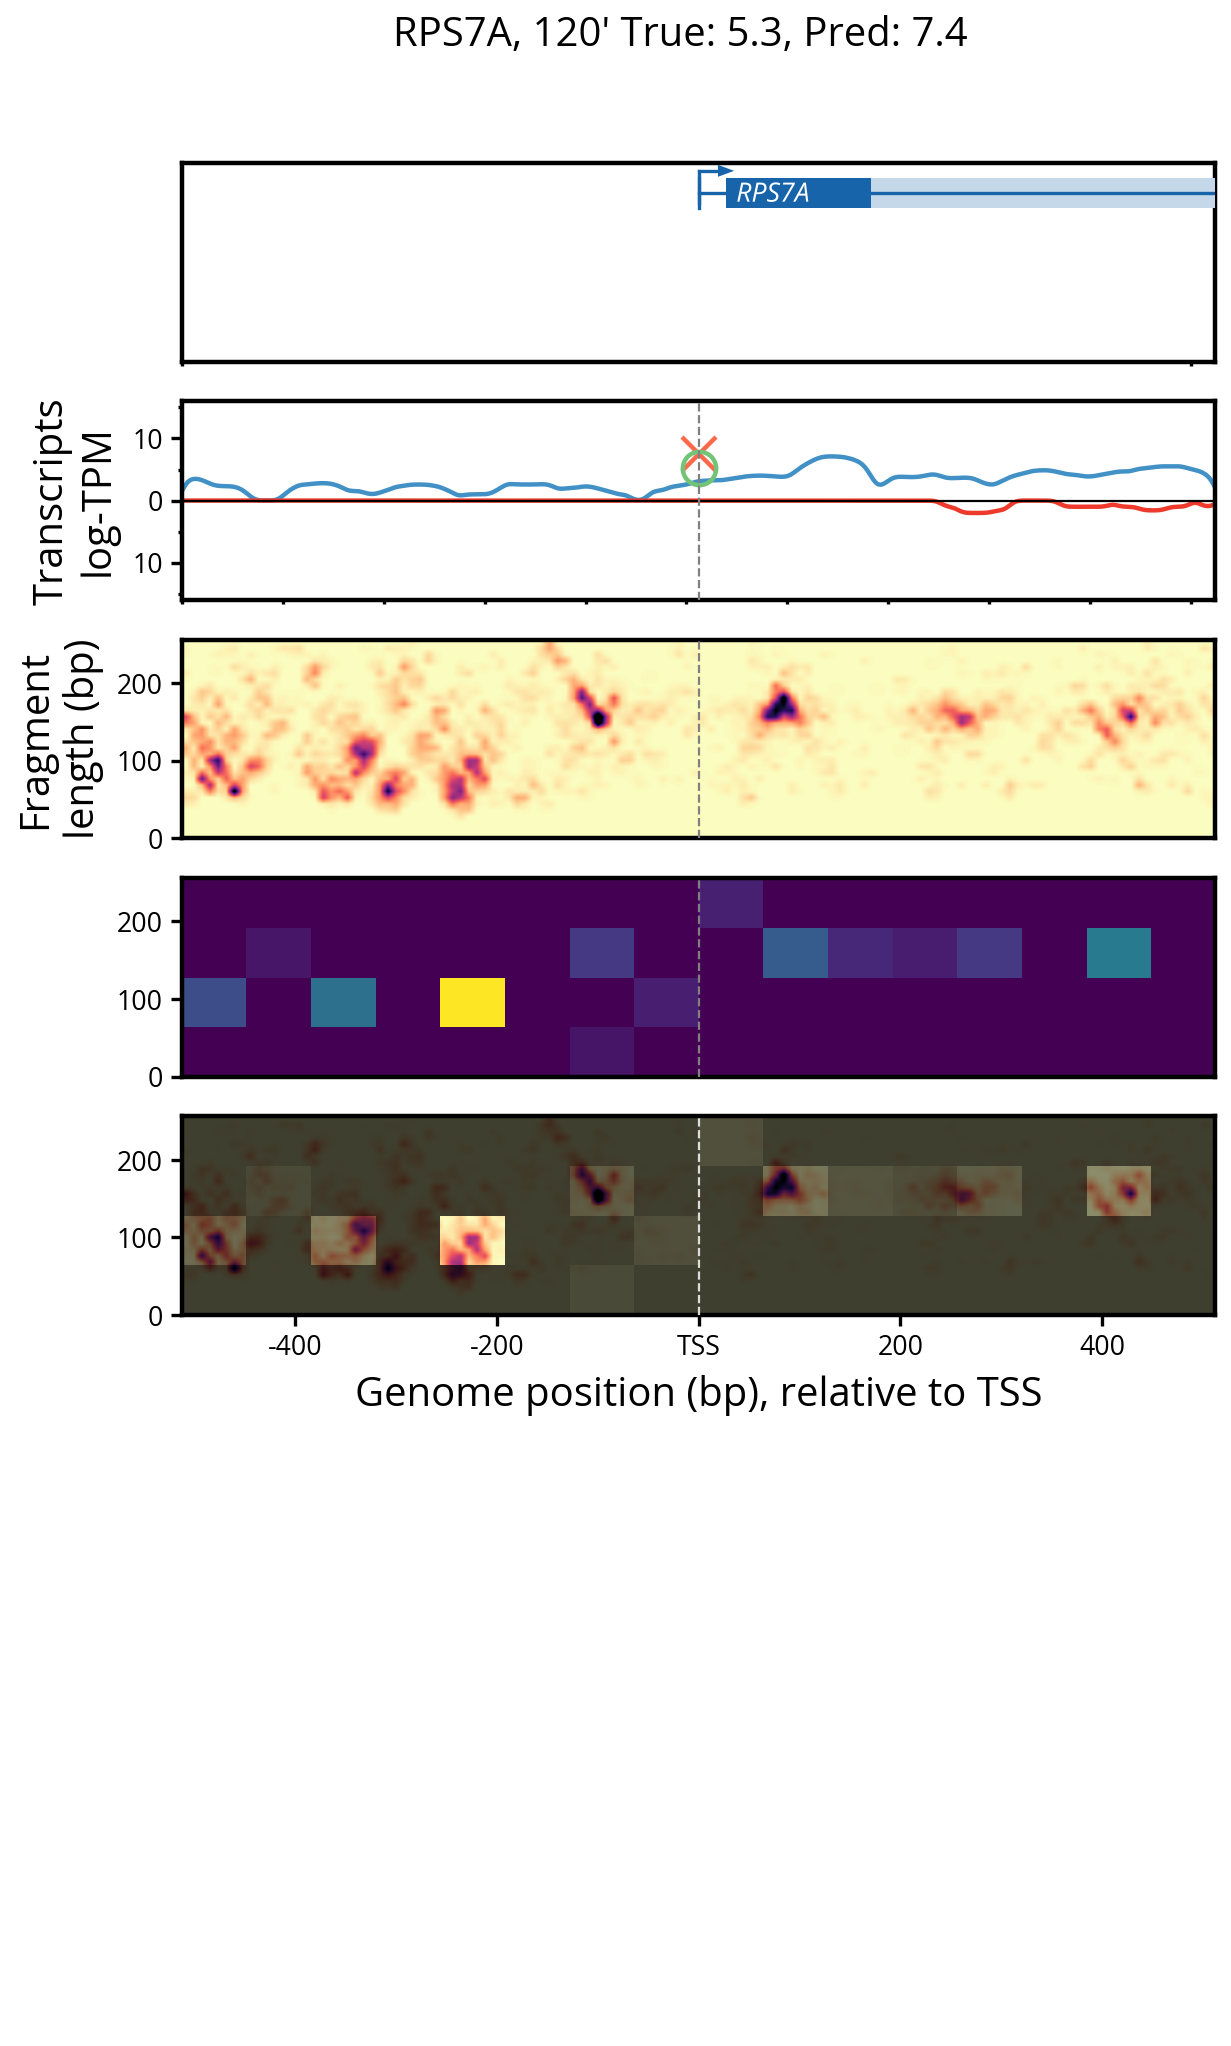

In [510]:
vit_analysis.plot_gene('RPS7A', 120.0)
0
